### 1. Import library

In [38]:
import os
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import random_split
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torchvision import transforms, models

from transformers import AutoTokenizer
from einops import rearrange

from torchinfo import summary

from model import DecoderLayer, Captioner
from data_loader import *
from train_utils import NoamScheduler, captioner_train, captioner_test
from inference_utils import translation

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


### 2. Set Params

In [2]:
# Data directory
DATA_DIR = "./flickr8k"
img_dir = os.path.join(DATA_DIR, "Flickr8k_Dataset")
annotations_file = os.path.join(DATA_DIR, "Flickr8k_text/Flickr8k.token.txt")

# Hyperparams
BATCH_SIZE = 64
MAX_LEN = 50 # 512
IMG_SIZE = 224

IMG_TRANSFORM = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

### 3. Load Tokenizer

In [3]:
# Tokenizer
TOKENIZER_NAME = "nlpconnect/vit-gpt2-image-captioning" #"Helsinki-NLP/opus-mt-ko-en"
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, clean_up_tokenization_spaces = True)
tokenizer.add_special_tokens({'pad_token': '<pad>', 'eos_token': '</s>'})
vocab_size = len(tokenizer)

eos_idx = tokenizer.eos_token_id
pad_idx = tokenizer.pad_token_id
print(f"eos_idx: {eos_idx}")
print(f"pad_idx: {pad_idx}")
print(f"vocab_size: {vocab_size}")

eos_idx: 50258
pad_idx: 50257
vocab_size: 50259


### 4. Set DataLoader

In [4]:
dataset = ImgCaptionDataset(img_dir = img_dir,
                            annotations_file = annotations_file,
                            img_transform = IMG_TRANSFORM)

In [5]:
len_train = len(dataset) * 0.8
len_test = len(dataset) - len_train
len_val = len_train * 0.15
len_train -= len_val

len_train = round(len_train)
len_val = round(len_val)
len_test = round(len_test)

print(len_train, len_val, len_test)

27509 4855 8091


In [6]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [len_train, len_val, len_test])

In [7]:
train_loader = ImgCapDataLoader(dataset = train_dataset,
                                batch_size = BATCH_SIZE,
                                tokenizer = tokenizer,
                                max_len = MAX_LEN,
                                shuffle = True)

val_loader = ImgCapDataLoader(dataset = val_dataset,
                                batch_size = BATCH_SIZE,
                                tokenizer = tokenizer,
                                max_len = MAX_LEN,
                                shuffle = False)

test_loader = ImgCapDataLoader(dataset = test_dataset,
                                batch_size = BATCH_SIZE,
                                tokenizer = tokenizer,
                                max_len = MAX_LEN,
                                shuffle = False)

### 5. Load Model

In [8]:
num_layers = 2 # 6
d_model = 128 # 512
drop_p = 0.2 #0.2
n_heads = 8

In [9]:
feature_extractor = models.efficientnet_b0(weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1).features
feature_channel = get_feature_channel_num(feature_extractor, (1, 3, IMG_SIZE, IMG_SIZE))

model =  Captioner(feature_extractor, feature_channel, num_layers, d_model, MAX_LEN, n_heads, vocab_size, drop_p, pad_idx, DEVICE)
model = model.to(DEVICE)

(imgs, input_tokens), label_tokens = next(iter(train_loader))
summary(model, input_data = (imgs, input_tokens), device=DEVICE)

Layer (type:depth-idx)                                  Output Shape              Param #
Captioner                                               [64, 29, 50259]           --
├─Sequential: 1-1                                       [64, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [64, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [64, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [64, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [64, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [64, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [64, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [64, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [64, 24, 56, 56]          6,004
│    │    └─MBConv: 3-6                              

### 6. Train

In [24]:
EPOCHS = 50
LAMBDA = 0 # L2-Regularization을 위한 hyperparam

criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)
scheduler_name = "Noam" #Cos

## Noam ##
warmup_steps = 1500
LR_scale = 0.1

## Cos ##
LR_init = 5e-4
T0 = 1500 # 첫 주기
T_mult = 2 # 배 만큼 주기가 길어짐. (1 보다 큰 정수여야 함.)

NEW_MODEL_TRAIN = False
save_model_path = "./results/captioner.pt"
save_history_path = "./results/captioner_history.pt"

In [25]:
if NEW_MODEL_TRAIN:
    params = [p for p in model.parameters() if p.requires_grad]
    if scheduler_name == "Noam":
        optimizer = optim.Adam(params, lr = 0,
                               betas = (0.9, 0.98), eps = 1e-9,
                               weight_decay = LAMBDA)
        scheduler = NoamScheduler(optimizer, d_model, warmup_steps, LR_scale)
    elif scheduler_name == "Cos":
        optimizer = optim.Adam(params, lr = LR_init,
                               betas = (0.9, 0.98), eps = 1e-9,
                               weight_decay = LAMBDA)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T0, T_mult)
    
    captioner_train(model, train_loader, val_loader,
                    criterion, optimizer, scheduler, EPOCHS,
                    save_model_path, save_history_path, device = DEVICE)

In [26]:
# save_model_path = "./results/captioner.pt"
loaded = torch.load(save_model_path, map_location=DEVICE, weights_only=False)
load_model = loaded["model"]
ep = loaded["epoch"]
optimizer = loaded["optimizer"]

loaded = torch.load(save_history_path, map_location=DEVICE, weights_only = False)
loss_history = loaded["loss_history"]

print(ep)
print(optimizer)

17
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.98)
    capturable: False
    differentiable: False
    eps: 1e-09
    foreach: None
    fused: None
    lr: 0.00010046725461883587
    maximize: False
    weight_decay: 0
)


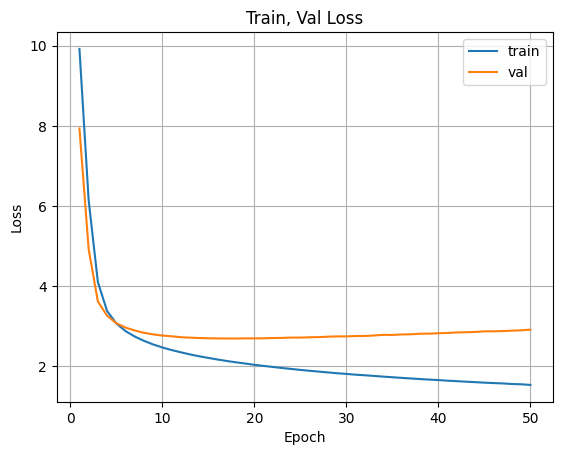

In [27]:
plt.figure()
plt.plot(range(1,EPOCHS+1),loss_history["train"], label="train")
plt.plot(range(1,EPOCHS+1),loss_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.grid()
plt.legend()

### 7. Test

In [ ]:
captioner_test(load_model, test_loader, criterion, device = DEVICE)

</s> Two dogs are play in the grass. </s>


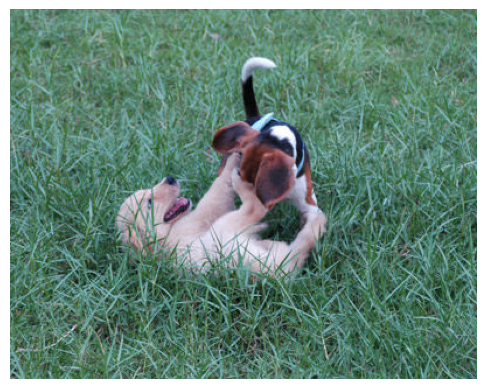

In [37]:
test_img_path = "./flickr8k/Flickr8k_Dataset/23445819_3a458716c1.jpg"
print(translation(load_model, tokenizer, IMG_TRANSFORM, test_img_path, MAX_LEN, DEVICE))
plt.imshow(Image.open(test_img_path))
plt.axis('off')
plt.show()